# Lab: Introduction to Notebooks for SPSS Professionals - Part 1

## Introduction

The purpose of this lab is to help professionals who currently use SPSS Modeler understand how a data scientist can use notebooks for implementing various analytics use cases. 

We chose a simple analytics use case for this lab - predicting mortgage default. We are using different predictive models (C5 classification model in SPSS and Spark ML Random Forest Classifier in the notebook) because we want to focus on explaining functionality, and not comparing performance or accuracy.  


## Notebooks

This notebook IDE is built on top of open source Jupyter notebooks. A notebook is a file type that contains 
1. Code (Python, R or Scala)
2. Markdown (comments like the ones you are reading now)
3. A connection to a kernel (runtime environment). The kernel in this environment is provided by Spark. 

The content of a notebook is organized in "cells". The two main types of cells are "code" and "markdown". As you review the rest of the notebook, you may see some text that's marked with "out". The "out" tag is for output of code directly above it. If you don't see the out tag, then the output may have been cleared or the code in the cell didn't produce any printable output. 

While notebook IDE looks different from SPSS Modeler, these tools have several similarities on the technical level. When we run a Modeler stream, the visual nodes are converted to code which is executed in Modeler server. When we run notebooks, the code that we provide runs in the specific kernel for each programming language (the notebook IDE automatically starts a kernel for the programming language in which the notebook is implemented). 

You will notice that the notebook IDE has a menu that's dedicated to kernels with actions like Start, Restart, Reconnect, etc. This is similar to connections to Modeler Server. Notebook IDE offers more flexibility for connections to the kernel and the ability to switch kernels because several versions of programming languages are supported. 

When we work with notebooks, we have an option to run the entire notebook (all cells in the notebook) or individual cells. This is similar to running the entire Modeler stream or a just selected branch. If you are running individual cells, it's important that the cells above it had been run. Again, this is similar to Modeler (we don't start execution in the middle of the stream, and if we do, we turn on caching). 

If you want to run a cell, position the cursor at the end of the last line in the cell, and select menu Cell -> Run Cells (or click the Run icon). When the cell is running, you will see an  asterisks next to the cell [*]. Don't run any subsequent cells until execution is done.  


Since Notebooks are based on an open source technlogy, you can find many tutorials and sample Notebooks. 
Here are some notebooks that show "functional/technical" features of Python and R: https://github.com/IBMDataScience/sample-notebooks
You can find additional notebooks on the Community page of DSX.


## Sample Modeler Stream

Start with reviewing the sample Modeler stream that was provided by your instructor (MortgageDefault.str). In this lab we'll implement the same use case using Python and SparkML.

![Mortgage Default SPSS stream](https://ibm.box.com/shared/static/hye9foibsh7wvexdfyp8h30pgpnc3cs3.jpg)

## Working with a Notebook
Until you click the Edit icon (pencil in the top right corner), you are looking at the "static" version of the notebook (i.e. it's simply displaying the content of the file, and it's not connected to a kernel). 

After you click the Edit icon, notice the "Kernel starting" message in the top right corner. You should also see a menu bar becuase we have opened the notebook IDE. 

Explore the menu options and let the instructor know if you have any questions. We'll use some of the menu options in this lab. 

As you are working on this lab, read the information in the markdown cells. To run code in each cell, position cursor at the end of the last line of code cell and click the Run icon. As mentioned earlier, the cell is still running if you see [*] next to the code cell, and not every cell will have printed output.  


## Mortgage Default Use Case Implementation

### Step 1: Connect to Object Storage

We start with connecting to Object Storage. Object Storage is the Bluemix environment for storing flat files. 

You have loaded the data files as one of the first steps in the lab instructions, but the following code is connecting to one of the instructors' Object Storage. You can use this notebook without any changes. **If you would like to load data files to your own Object Storage, please check with the lab instructor or see Appendix A of the lab instructions document**.  


In [8]:
from pyspark.sql import SparkSession

# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_18c4556616c5444581b1cb6d212cf2dc(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '879160f1a1174d2f912f196ac158ffbf')
    hconf.set(prefix + '.username', 'aa5ea4cb9c48463681897f88b4a9ab08')
    hconf.set(prefix + '.password', 'veCB_4)bYn362UU&')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_18c4556616c5444581b1cb6d212cf2dc(name)

spark = SparkSession.builder.getOrCreate()

### Step 2: Load files

In [9]:
# The loan default information
default = spark.read.format('csv')\
  .options(header='true', inferschema='true')\
  .load("swift://IntroToNotebooks." + name + "/Default.csv")

# The property information
property = spark.read.format('csv')\
  .options(header='true', inferschema='true')\
  .load("swift://IntroToNotebooks." + name + "/Property.csv")

# Customer information
customer = spark.read.format('csv')\
  .options(header='true', inferschema='true')\
  .load("swift://IntroToNotebooks." + name + "/Customer.csv")



### Step 3: Merge Files
This step is similar to Merge node in Modeler

In [10]:
merged = customer.join(property, customer['ID'] == property['ID'])\
                   .join(default, customer['ID']==default['ID']).select(customer['*'],property['SalePrice'], property['Location'], default['MortgageDefault'])
# Preview  5 rows
merged.toPandas().head()

,ID,Income,AppliedOnline,Residence,Yrs at Current Address,Yrs with Current Employer,Number of Cards,Creditcard Debt,Loans,Loan Amount,SalePrice,Location,MortgageDefault
0,100522,43982,YES,Owner Occupier,13,11,2,1055,0,9405,500000,110,NO
1,101756,59944,YES,Owner Occupier,20,11,2,3894,0,9880,750000,110,NO
2,101354,57718,YES,Owner Occupier,25,16,2,1555,1,6285,155000,130,YES
3,100512,45621,YES,Owner Occupier,1,19,1,1878,0,9260,195000,100,YES
4,100537,45081,NO,Owner Occupier,14,15,2,713,1,8430,140000,110,NO


### Step 4: Rename some columns
This step is to remove spaces from columns names

In [11]:
merged = merged.withColumnRenamed("Yrs at Current Address", "YearCurrentAddress").withColumnRenamed("Yrs with Current Employer","YearsCurrentEmployer")\
                .withColumnRenamed("Number of Cards","NumberOfCards").withColumnRenamed("Creditcard Debt","CCDebt").withColumnRenamed("Loan Amount", "LoanAmount")
merged.toPandas().head()

,ID,Income,AppliedOnline,Residence,YearCurrentAddress,YearsCurrentEmployer,NumberOfCards,CCDebt,Loans,LoanAmount,SalePrice,Location,MortgageDefault
0,100522,43982,YES,Owner Occupier,13,11,2,1055,0,9405,500000,110,NO
1,101756,59944,YES,Owner Occupier,20,11,2,3894,0,9880,750000,110,NO
2,101354,57718,YES,Owner Occupier,25,16,2,1555,1,6285,155000,130,YES
3,100512,45621,YES,Owner Occupier,1,19,1,1878,0,9260,195000,100,YES
4,100537,45081,NO,Owner Occupier,14,15,2,713,1,8430,140000,110,NO


### Step 5: Data understanding
This capability is similar to graphboard in Modeler.

PixieDust is a Python Helper library for Spark IPython Notebooks. One of it's main features are visualizations. You'll notice that unlike other APIs which produce just output, PixieDust creates an **interactive UI** in which you can explore data.

More information about PixieDust: https://github.com/ibm-cds-labs/pixiedust?cm_mc_uid=78151411419314871783930&cm_mc_sid_50200000=1487962969


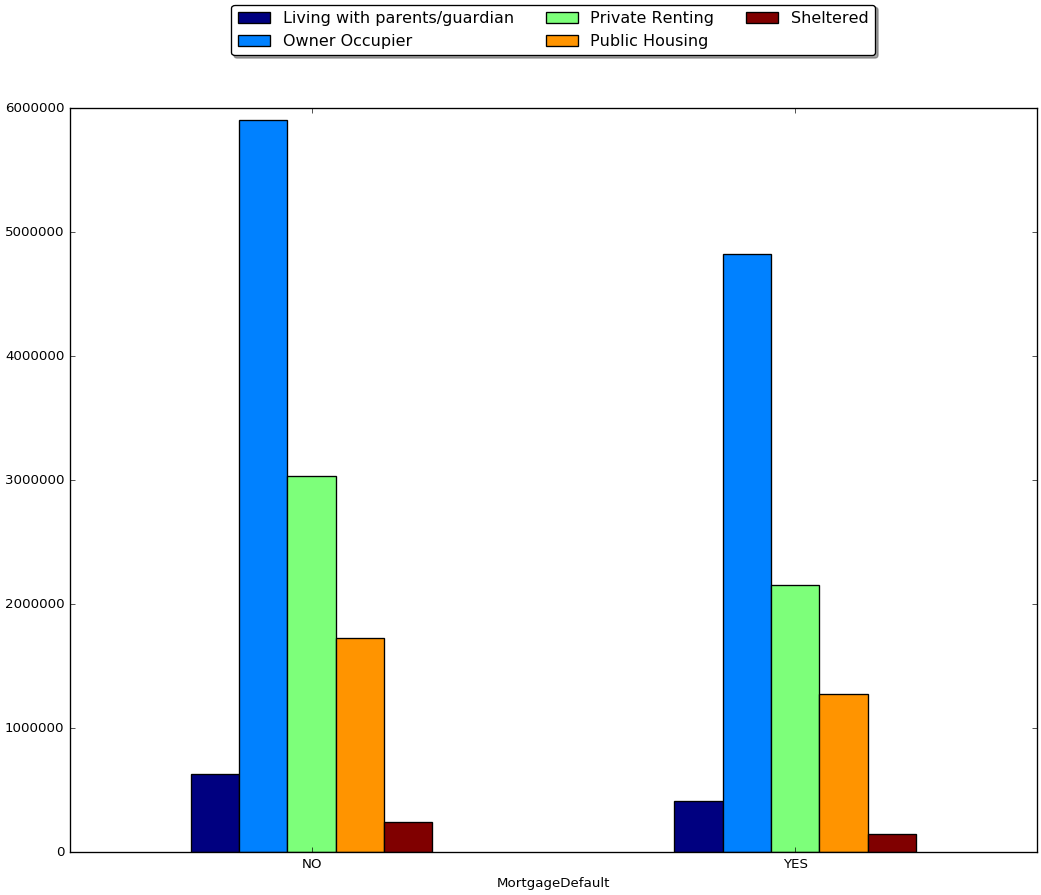

In [5]:
from pixiedust.display import *
display(merged)

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and more aggressive business users. The system interprets the language and produces visualizations using the user's choice of existing lower-level visualization technologies typically used by application engineers such as RAVE or D3.

More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

In [12]:
import brunel
Merged = merged.toPandas()
%brunel data('Merged') data('Merged') x(SalePrice) y(LoanAmount) point color(Residence) tooltip(LoanAmount, SalePrice) :: width=800, height=300 

<IPython.core.display.Javascript object>

In [13]:
%brunel data('Merged') bar x(MortgageDefault) y(Income) mean(Income) color(Residence) stack tooltip(SalePrice) | bubble size(SalePrice) color(YearCurrentAddress:reds-blues) tooltip(SalePrice, Residence) :: width=1200, height=350

<IPython.core.display.Javascript object>

In [15]:
# Spark SQL also allow you to use standard SQL to query the data set
customer.createOrReplaceTempView("customer")
property.createOrReplaceTempView("property")
default.createOrReplaceTempView("default")


sql = """

SELECT c.*
    , p.SalePrice
    , p.Location
    , d.MortgageDefault
FROM customer c
INNER JOIN property p
    on c.ID = p.ID
INNER JOIN default d
    on c.ID = d.ID
WHERE c.Income<50000 
    
"""
spark.sql(sql).toPandas().head()

,ID,Income,AppliedOnline,Residence,Yrs at Current Address,Yrs with Current Employer,Number of Cards,Creditcard Debt,Loans,Loan Amount,SalePrice,Location,MortgageDefault
0,100522,43982,YES,Owner Occupier,13,11,2,1055,0,9405,500000,110,NO
1,100512,45621,YES,Owner Occupier,1,19,1,1878,0,9260,195000,100,YES
2,100537,45081,NO,Owner Occupier,14,15,2,713,1,8430,140000,110,NO
3,100458,46645,NO,Owner Occupier,19,4,1,884,0,6045,475000,110,NO
4,101430,45066,YES,Private Renting,16,15,1,860,1,6605,255000,100,YES


### Step 6: Build the Spark pipeline and the Random Forest model
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [17]:
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier


# Prepare string variables so that they can be used by the decision tree algorithm
stringIndexer1 = StringIndexer(inputCol='AppliedOnline', outputCol='AppliedOnlineEncoded')
stringIndexer2 = StringIndexer(inputCol='Residence',outputCol='ResidenceEncoded')
stringIndexer3 = StringIndexer(inputCol='MortgageDefault', outputCol='label')

# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["Income", "AppliedOnlineEncoded", "ResidenceEncoded", "YearCurrentAddress", "YearsCurrentEmployer", "NumberOfCards", \
                                       "CCDebt", "Loans", "LoanAmount", "SalePrice", "Location"], outputCol="features")

# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[stringIndexer1, stringIndexer2, stringIndexer3, assembler, rf])

In [18]:
# Split data into train and test datasets
train, test = merged.randomSplit([80.0,20.0], seed=6)

In [19]:
# Build model
model = pipeline.fit(train)

### Step 7: Score the test data set

In [20]:
result=model.transform(test)
result.toPandas().head(3)

,ID,Income,AppliedOnline,Residence,YearCurrentAddress,YearsCurrentEmployer,NumberOfCards,CCDebt,Loans,LoanAmount,SalePrice,Location,MortgageDefault,AppliedOnlineEncoded,ResidenceEncoded,label,features,rawPrediction,probability,prediction
0,100282,45715,YES,Owner Occupier,8,14,2,772,1,12985,137000,100,NO,0,0,0,"[45715.0, 0.0, 0.0, 8.0, 14.0, 2.0, 772.0, 1.0...","[15.6435183647, 4.35648163526]","[0.782175918237, 0.217824081763]",0
1,100284,45049,YES,Public Housing,6,16,2,1345,1,9085,280000,110,NO,0,2,0,"[45049.0, 0.0, 2.0, 6.0, 16.0, 2.0, 1345.0, 1....","[9.33205708605, 10.667942914]","[0.466602854302, 0.533397145698]",1
2,100285,44974,YES,Public Housing,14,18,2,2772,0,9515,264000,130,NO,0,2,0,"[44974.0, 0.0, 2.0, 14.0, 18.0, 2.0, 2772.0, 0...","[10.6930512158, 9.30694878424]","[0.534652560788, 0.465347439212]",0


### Step 8: Model Analysis
Compare the precision of the two models, this is similar to Analysis node in Modeler.  

In [21]:
print 'Model Accuracy = {:.2f}.'.format(result.filter(result.label == result.prediction).count() / float(result.count()))

Model Accuracy = 0.63.


### Step 9: Model Evaluation
This step is similar to the Evaluation node in Modeler

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print 'Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(result))

Area under ROC curve = 0.63.


### Step 10: Tune the model to find the best model
Build a Parameter Grid specifying the parameters to be evaluated to determine the best combination

In [23]:
# set different levels for the maxDepth
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder().addGrid(rf.maxDepth,[4,5,6,8,10]).build())

#### Create a cross validator to tune the pipeline with the generated parameter grid
Cross-validation attempts to fit the underlying estimator with user-specified combinations of parameters, cross-evaluate the fitted models, and output the best one.

In [24]:
# perform 3 fold cross validation
cv = CrossValidator().setEstimator(pipeline).setEvaluator(evaluator).setEstimatorParamMaps(paramGrid).setNumFolds(3)

In [25]:
# train the model
cvModel = cv.fit(train)

# pick the best model
best_rfModel = cvModel.bestModel

# score the test data set
cvresult=best_rfModel.transform(test)

In [27]:
print 'Model Accuracy of the best fitted model = {:.2f}.'.format(cvresult.filter(cvresult.label == cvresult.prediction).count()/ float(cvresult.count()))
print 'Model Accuracy of the default model = {:.2f}.'.format(result.filter(result.label == result.prediction).count() / float(result.count()))
print '   '
print('Area under the ROC curve of best fitted model = {:.2f}.'.format(evaluator.evaluate(cvresult)))
print 'Area under the ROC curve of the default model = {:.2f}.'.format(evaluator.evaluate(result))

Model Accuracy of the best fitted model = 0.73.
Model Accuracy of the default model = 0.63.
   
Area under the ROC curve of best fitted model = 0.74.
Area under the ROC curve of the default model = 0.63.


### Step 11: Save Model
Save model in Object Storage. 

In [29]:
# Pick the best model and save it
# Overwrite any existing saved model in the specified path
best_rfModel.write().overwrite().save("IntroToNotebooks.mortgageDefaultModel")
print"Saved model"

Saved model


A separate notebook has been created for "batch scoring deployment". This deployment notebook retrieves the model from object storage and applies it to a new dataset. The notebook can be scheduled to run via the Notebook scheduler (the clock icon on the menu bar) or through the deployment interface in IBM ML (currently in beta).

### You have finished Part 1 of the lab. Follow steps in the lab instructions document to upload and test the model scoring notebook. 

**Authors**
* Mokhtar Kandil
* Elena Lowery
* Sidney Phoon
* Rich Tarro